# Problem 2: Implementing a Multi-layer Perceptron

PRAKHAR BHARDWAJ

prakharb

Q2

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os
from tqdm import tqdm

import csv
import zipfile

In [7]:
#!pip install seaborn
# Install seaborn (needed to plot confusion matrix) by uncommenting the above line

## Create functions to calculate forward pass & backward propagation.

Dataset = A mini batch of Fashion-MNIST dataset
1. M = # of features = 784
2. D = # of hidden nodes (hidden units) = 256
3. K = # of classes = 10

In [30]:
def sigmoid_forward(a): 
    # calculates the sigmoid activation function
    # a: pre-activation values (nodes in hidden layer)
    # returns: activated values

    z = 1/(np.exp(-a)+1) 
    return z

def sigmoid_backward(grad_accum, a): 
    # grad_accum: the gradient of the loss function w.r.t to z
    # a: the pre-activation values
    # returns: the gradient of the loss w.r.t to the preactivation values, a
    
    # derivative of sigmoid = sigmoid(a)*(1-sigmoid(a))
    sig_grad = sigmoid_forward(a) * (1 - sigmoid_forward(a))
    dl_da = grad_accum.reshape(-1,1) * sig_grad.reshape(-1,1)
    return dl_da


def linear_forward(x, weight, bias):
    # Computes the forward pass of the linear layer
    # x: input of layer
    # weight, bias: weights and bias of neural network layer
    # returns: output of linear layer
    
    return np.dot(weight, x) + bias


def linear_backward(grad_accum, x, weight, bias): 
    
    dl_dw = np.dot(grad_accum.reshape(1, -1).T, x.reshape(-1,1).T)

    dl_dbias = grad_accum.reshape(1,-1)
    
    dl_dx = np.dot(weight.T, grad_accum.reshape(-1, 1))
    
    return dl_dw, dl_dbias, dl_dx
    


def softmax_xeloss_forward(b, labels): 
    # Input parameters: 
    # b: pre-activation 
    # calculates the softmax of the vector b
    # calculates the cross entropy loss between the softmax of b and the labels 
    # returns: l
    
    yhat = np.divide(np.exp(b), np.sum(np.exp(b), axis=0)) 
    # cross entropy loss = sum of -ylog(y_hat)
    a = b.shape[0]
    L = np.multiply(-1/a, np.sum(labels*np.log(yhat), axis=0))
    return yhat, L

def softmax_xeloss_backward(yhat, labels): 
    # Input parameters:
    # yhat: predictions of the neural network
    # labels: target of the network
    # returns: dl_db gradient of loss w.r.t to b
    dl_db = (yhat - labels) 
    return dl_db
      
def data_load(data_zip = 'fashion_mnist.zip'):
    # load in the data provided in "data/"
    # Unzip fashion_mnist.zip
    with zipfile.ZipFile(data_zip, 'r') as ZipObject:
        ZipObject.extractall('data/')

        
def load_params():
    alpha_weights = np.loadtxt('alpha1.txt', delimiter=',')
    beta_weights = np.loadtxt('alpha2.txt', delimiter=',')
    alpha_bias= np.loadtxt('beta1.txt', delimiter=',')
    beta_bias = np.loadtxt('beta2.txt', delimiter=',')
    return alpha_weights, beta_weights, alpha_bias, beta_bias


def one_hot_encode(y):
    # convert categorical target features to one hot encoded data
    return pd.get_dummies(y.flatten()).to_numpy()


def train(batchsize=1 , eta = 0.01, num_epochs=100, h = 256, init='default'):
    
    ## Extract MNIST dataset
    directory = "data" # diretory (path)
    # Check whether the specified directory exists in cwd or not
    path = os.path.exists(directory)
    if not path: # if data has not been extracted
        data_load() # extract data
        print(f'The data has been extracted and saved in the directory:"{directory}"')
    
    # load x_train & y_train data
    xy_train = np.loadtxt('data/train.csv', dtype=str, delimiter=",")
    xy_train = xy_train.astype(float)
    print('The shape of x & y train data:', xy_train.shape)

    
    x_train = np.hsplit(xy_train, np.array([784]))[0] #verticle split
    print('The shape of x_train:', x_train.shape)

    
    y_train = np.hsplit(xy_train, np.array([784]))[1] 
    print('The shape of y_train:', y_train.shape)
    
    
    xy_test = np.loadtxt('data/test.csv', dtype=str, delimiter=",")
    xy_test = xy_test.astype(float)
    print('The shape of x & y test data:', xy_test.shape)

    
    x_test = np.hsplit(xy_test, np.array([784]))[0] # split vertically
    print('The shape of x_test:', x_test.shape)

    y_test = np.hsplit(xy_test, np.array([784]))[1] # split vertically
    print('The shape of y_test:', y_test.shape)
    print('\n')
    
    
    # one hot encode labels
    y_train = one_hot_encode(y_train)
    y_test = one_hot_encode(y_test)
    
    
    # load initial weights and bias
    if init == 'default':
        alpha, beta, alpha_bias, beta_bias = load_params()
    elif init=='zeros':
        # initialize weights and biases to 0
        alpha = np.zeros([h,784])
        beta = np.zeros([10, h])
        alpha_bias = np.zeros(h)
        beta_bias = np.zeros(10)
    elif init=='ones':
        # initialize weights and biases to 1
        alpha = np.ones([h,784])
        beta = np.ones([10, h])
        alpha_bias = np.ones(h)
        beta_bias = np.ones(10)
    elif init=='random':
        # initialize weights and biases to random values between -1 and 1
        alpha = np.random.uniform(low=-1, high=1, size=(256,784))
        beta = np.random.uniform(low=-1, high=1, size=(10,256))
        alpha_bias = np.random.uniform(low=-1, high=1, size=(256))
        beta_bias = np.random.uniform(low=-1, high=1, size=(10))
    
    alpha_bias = alpha_bias.reshape(-1,1)
    beta_bias = beta_bias.reshape(-1,1)
    
    
    # initialized arrays to store losses and accuracy
    train_loss_list = []
    test_loss_list = []

    for epoch in range(num_epochs):
        acc = 0 
        batch = 0 
        train_loss_tot = 0
        
        dl_dalpha_sum = 0
        dl_dbeta_sum = 0
        dl_dalphabias_sum = 0
        dl_dbetabias_sum = 0
        # Iterate over batches of data (do not shuffle data)
        for i in tqdm(range(len(x_train))):
            x = x_train[i].reshape(-1,1)
            y = y_train[i].reshape(-1,1)

           
            a = linear_forward(x, alpha, alpha_bias)
          
            z = sigmoid_forward(a)
            ## OUTPUT LAYER:
            # preactivated output layer nodes
            b = linear_forward(z, beta, beta_bias)
            b_to_l = softmax_xeloss_forward(b, y)
            # y_pred
            yhat = b_to_l[0]
            # cross entropy loss of softmax-activated nodes
            L = b_to_l[1]
            
            train_loss_tot += L
            
            ######## BACKWARD 
            ## OUTPUT LAYER:
            # dL/db
            dl_db = softmax_xeloss_backward(yhat, y)
            ## HIDDEN LAYER:
            l_to_z = linear_backward(dl_db, z, beta, beta_bias) # z is from feed forward
            # dL/dbeta
            dl_dbeta = l_to_z[0] 
            # dL/dbetabias
            dl_dbetabias = l_to_z[1]
            # dL/dz
            dl_dz = l_to_z[2]
            # dL/da
            dl_da = sigmoid_backward(dl_dz, a) 
            ## INPUT LAYER:
            # input layer nodes
            l_to_x = linear_backward(dl_da, x, alpha, alpha_bias) 
            # dL/dalpha
            dl_dalpha = l_to_x[0] 
            # dL/dalphabias
            dl_dalphabias = l_to_x[1]
            # dL/dx
            dl_dx = l_to_x[2]
            
            ######## UPDATE RULES (update weights and biases at every batch)
            dl_dalpha_sum += dl_dalpha
            dl_dbeta_sum += dl_dbeta
            dl_dalphabias_sum += dl_dalphabias
            dl_dbetabias_sum += dl_dbetabias
            if (i+1) % batchsize == 0:
                alpha = alpha - eta*dl_dalpha_sum/batchsize
                beta = beta - eta*dl_dbeta_sum/batchsize
                alpha_bias = alpha_bias - eta*dl_dalphabias_sum.T/batchsize
                beta_bias = beta_bias - eta*dl_dbetabias_sum.T/batchsize
                
                # reset
                dl_dalpha_sum = 0
                dl_dbeta_sum = 0
                dl_dalphabias_sum = 0
                dl_dbetabias_sum = 0
            
            ######## ACCURACY
            acc += (np.argmax(yhat)==np.argmax(y)) 
            batch += 1 
        
        # printout train accuracy at each epoch
        print(f'epochs: {epoch}, Train Accuracy: {acc/batch * 100}%')
        
        # store train loss for each epoch
        train_loss_list.append(train_loss_tot/3000)
        
        # calculate test predictions and loss at each epoch
        acc = 0
        batch = 0
        yhat_test_class = []
        test_loss_tot = 0
        for j in range(len(x_test)): 
            x = x_test[j].reshape(-1,1)
            y = y_test[j].reshape(-1,1)
            
            ######## FEED FORWARD 
            ## HIDDEN LAYER:
            
            a = linear_forward(x, alpha, alpha_bias)
           
            z = sigmoid_forward(a)
            ## OUTPUT LAYER:
           
            b = linear_forward(z, beta, beta_bias)
            b_to_l = softmax_xeloss_forward(b, y)
            # y_pred
            yhat = b_to_l[0]
            L = b_to_l[1]            
            test_loss_tot += L
            # calculate test accuracy
            acc += (np.argmax(yhat)==np.argmax(y)) 
            batch += 1
            
            # test set predictions (y_pred from test set)
            yhat_test_class = np.append(yhat_test_class, np.argmax(yhat))
            
        # printout test accuracy at each epoch
        print(f'epochs: {epoch+1}, Test Accuracy: {acc/batch * 100}%')
        
        # store test loss for each epoch
        test_loss_list.append(test_loss_tot/1000)
        
    return alpha, beta, alpha_bias, beta_bias, acc, train_loss_list, test_loss_list, yhat_test_class
    


In [9]:
results = train(batchsize=1 , eta = 0.01, num_epochs=20, h = 256, init='default')


The data has been extracted and saved in the directory:"data"
The shape of x & y train data: (3000, 785)
The shape of x_train: (3000, 784)
The shape of y_train: (3000, 1)
The shape of x & y test data: (1000, 785)
The shape of x_test: (1000, 784)
The shape of y_test: (1000, 1)




100%|██████████| 3000/3000 [00:12<00:00, 246.05it/s]


epochs: 0, Train Accuracy: 55.96666666666666%
epochs: 1, Test Accuracy: 66.3%


100%|██████████| 3000/3000 [00:11<00:00, 268.04it/s]


epochs: 1, Train Accuracy: 71.43333333333334%
epochs: 2, Test Accuracy: 69.8%


100%|██████████| 3000/3000 [00:11<00:00, 255.50it/s]


epochs: 2, Train Accuracy: 75.76666666666667%
epochs: 3, Test Accuracy: 70.89999999999999%


100%|██████████| 3000/3000 [00:13<00:00, 221.62it/s]


epochs: 3, Train Accuracy: 79.46666666666667%
epochs: 4, Test Accuracy: 72.2%


100%|██████████| 3000/3000 [00:11<00:00, 257.95it/s]


epochs: 4, Train Accuracy: 81.26666666666667%
epochs: 5, Test Accuracy: 72.39999999999999%


100%|██████████| 3000/3000 [00:12<00:00, 240.90it/s]


epochs: 5, Train Accuracy: 83.3%
epochs: 6, Test Accuracy: 73.2%


100%|██████████| 3000/3000 [00:12<00:00, 249.80it/s]


epochs: 6, Train Accuracy: 84.96666666666667%
epochs: 7, Test Accuracy: 73.5%


100%|██████████| 3000/3000 [00:12<00:00, 249.28it/s]


epochs: 7, Train Accuracy: 86.63333333333333%
epochs: 8, Test Accuracy: 74.4%


100%|██████████| 3000/3000 [00:12<00:00, 239.14it/s]


epochs: 8, Train Accuracy: 88.56666666666668%
epochs: 9, Test Accuracy: 75.0%


100%|██████████| 3000/3000 [00:11<00:00, 252.73it/s]


epochs: 9, Train Accuracy: 89.93333333333334%
epochs: 10, Test Accuracy: 75.9%


100%|██████████| 3000/3000 [00:11<00:00, 255.10it/s]


epochs: 10, Train Accuracy: 90.93333333333334%
epochs: 11, Test Accuracy: 76.3%


100%|██████████| 3000/3000 [00:11<00:00, 262.53it/s]


epochs: 11, Train Accuracy: 91.7%
epochs: 12, Test Accuracy: 76.4%


100%|██████████| 3000/3000 [00:13<00:00, 217.51it/s]


epochs: 12, Train Accuracy: 92.4%
epochs: 13, Test Accuracy: 76.3%


100%|██████████| 3000/3000 [00:11<00:00, 252.85it/s]


epochs: 13, Train Accuracy: 93.10000000000001%
epochs: 14, Test Accuracy: 77.0%


100%|██████████| 3000/3000 [00:11<00:00, 264.35it/s]


epochs: 14, Train Accuracy: 93.93333333333334%
epochs: 15, Test Accuracy: 76.9%


100%|██████████| 3000/3000 [00:11<00:00, 256.59it/s]


epochs: 15, Train Accuracy: 94.56666666666666%
epochs: 16, Test Accuracy: 77.2%


100%|██████████| 3000/3000 [00:12<00:00, 249.45it/s]


epochs: 16, Train Accuracy: 95.1%
epochs: 17, Test Accuracy: 77.0%


100%|██████████| 3000/3000 [00:12<00:00, 248.20it/s]


epochs: 17, Train Accuracy: 95.7%
epochs: 18, Test Accuracy: 76.7%


100%|██████████| 3000/3000 [00:11<00:00, 253.79it/s]


epochs: 18, Train Accuracy: 96.0%
epochs: 19, Test Accuracy: 77.0%


100%|██████████| 3000/3000 [00:11<00:00, 251.96it/s]


epochs: 19, Train Accuracy: 96.16666666666667%
epochs: 20, Test Accuracy: 77.10000000000001%


In [11]:
#print(results[0]) # alpha weights
#print(results[1]) # beta weights
#print(results[2]) # alpha bias
#print(results[3]) # beta bias


[[ 0.60556094  0.64251342  0.05719769 ... -1.07437975 -0.90544484
  -0.69417979]
 [-0.68366859 -0.2859098   0.1710004  ...  0.5742716  -0.25100886
   0.19137132]
 [-1.36693525 -0.72849636  1.32733563 ...  1.79037211 -0.06089595
  -1.1964199 ]
 ...
 [ 1.01780908 -0.7129331  -1.28087504 ... -0.6101767  -1.04511739
   0.35808765]
 [-0.12887038  0.31563416 -1.18218326 ...  2.30699913  0.03362666
  -0.47303666]
 [-1.56878674 -0.00803166 -0.69942799 ... -0.74694452  0.37257835
  -0.08937792]]
[[ 1.12150703 -0.7855394  -0.39743352 ...  0.34799753  0.44493597
   0.191203  ]
 [-2.07565708  1.30457082 -1.34137265 ...  0.10985056  0.71228189
  -1.67358894]
 [ 0.60908333  1.49220225  1.22452121 ... -1.17429708 -1.94073157
  -0.71198464]
 ...
 [ 0.78028752 -0.29842505 -1.08987105 ...  0.56945539  1.6107854
   0.67901575]
 [-0.24324094 -1.59740634 -0.09778913 ...  1.29233199  0.42826464
  -0.57909441]
 [ 0.81799139  0.7703427  -0.72344032 ... -0.7380797   0.91877806
   0.62392106]]
[[ 0.06231657]
 [

In [12]:
print(results[5]) # train loss list
print(results[6]) # test loss list

[array([0.24036281]), array([0.11820164]), array([0.08983834]), array([0.07326552]), array([0.06193647]), array([0.05330853]), array([0.04654209]), array([0.04116138]), array([0.03680125]), array([0.03312256]), array([0.02999362]), array([0.02730596]), array([0.02498208]), array([0.02297115]), array([0.02122476]), array([0.01970182]), array([0.01836858]), array([0.0171901]), array([0.01613435]), array([0.01517695])]
[array([0.15640226]), array([0.13888483]), array([0.12865524]), array([0.12232294]), array([0.11939964]), array([0.11683516]), array([0.1131551]), array([0.10894774]), array([0.1055918]), array([0.10289604]), array([0.10072258]), array([0.09902002]), array([0.09783671]), array([0.097076]), array([0.09660912]), array([0.0963307]), array([0.09616248]), array([0.09605844]), array([0.09600947]), array([0.09602584])]


# Plot Loss 

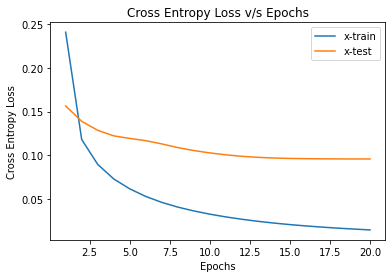

In [13]:
# Plot training loss, testing loss as a function of epochs
plt.title("Cross Entropy Loss v/s Epochs")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.plot(np.linspace(1,20,20), results[5])
plt.plot(np.linspace(1,20,20), results[6])
plt.legend(["x-train", "x-test"])
plt.show()

## Manually load train & test data.


In [14]:
xy_train = np.loadtxt('data/train.csv', dtype=str, delimiter=",")
xy_train = xy_train.astype(float)
print('The shape of x & y train data:', xy_train.shape)

x_train = np.hsplit(xy_train, np.array([784]))[0] 
print('The shape of x_train:', x_train.shape)

# y_train 
y_train = np.hsplit(xy_train, np.array([784]))[1] 
print('The shape of y_train:', y_train.shape)

The shape of x & y train data: (3000, 785)
The shape of x_train: (3000, 784)
The shape of y_train: (3000, 1)


In [15]:
xy_test = np.loadtxt('data/test.csv', dtype=str, delimiter=",")
xy_test = xy_test.astype(float)
print('The shape of x & y test data:', xy_test.shape)

x_test = np.hsplit(xy_test, np.array([784]))[0]
print('The shape of x_test:', x_test.shape)

y_test = np.hsplit(xy_test, np.array([784]))[1]
print('The shape of y_test:', y_test.shape)

The shape of x & y test data: (1000, 785)
The shape of x_test: (1000, 784)
The shape of y_test: (1000, 1)


# Confusion Matrix

In [16]:
def plot_confusion(yhat, y, title = '[Training or Test] Set'):
      
    pred_train = yhat
    true_train = y
    conf_train = np.zeros((10,10)) 
    for i in range(len(y)):
        conf_train[true_train[i], pred_train[i]] += int(1)
        
    sns.heatmap(conf_train, annot=True, fmt='.3g')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [17]:
# classes of test groundtruth labels
y_test_class = []
for row in one_hot_encode(y_test):
    y_test_class = np.append(y_test_class, np.argmax(row))
y_test_class = y_test_class.reshape(-1,1).astype(int)

print(y_test_class.shape)

(1000, 1)


In [18]:
# class of test predictions
yhat_test_class = results[7] # test set predictions (y_pred from test set)
yhat_test_class = yhat_test_class.reshape(-1,1).astype(int)
print(yhat_test_class.shape)


(1000, 1)


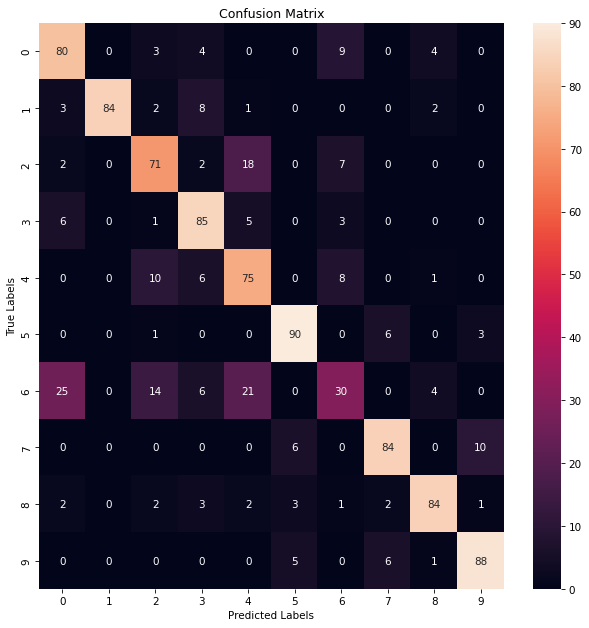

In [19]:
# Confusion matrix
plt.figure(figsize=(10, 10), dpi=75)
plot_confusion(yhat_test_class, y_test_class, title='Test Set')

# Correct and Incorrect Classification Samples

In [20]:
def plot_image(vector, out_f_name, label=None):
   
    image = np.asarray(vector).reshape(28, 28)
    plt.imshow(image, cmap='gray')
    if label:
        plt.title(label)
    plt.axis('off')
    plt.savefig(f'{out_f_name}.png', bbox_inches='tight')
    plt.show()

In [21]:
class_interest = 0 

In [22]:
# confusions (miss-predicted) images
conf_index = [] # will collect indicies of confusions
for i, cl in enumerate(yhat_test_class):
    if cl == class_interest and cl != y_test_class[i]:
        conf_index = np.append(conf_index, i) # indices of confusions
print(conf_index)
print(f'\nThere are {len(conf_index)} confusions (miss-predicted) images for class {class_interest}.')


[  7.  53. 133. 147. 150. 181. 244. 248. 250. 257. 308. 319. 367. 392.
 399. 413. 434. 442. 452. 485. 530. 545. 579. 612. 654. 670. 678. 749.
 770. 793. 825. 854. 855. 870. 896. 920. 943. 972.]

There are 38 confusions (miss-predicted) images for class 0.


In [23]:
# correctly predicted images
corr_index = [] # will collect indicies of correct predictions
for i, cl in enumerate(yhat_test_class):
    if cl == class_interest and cl == y_test_class[i]:
        corr_index = np.append(corr_index, i) 
print(corr_index)
print(f'\nThere are {len(corr_index)} correctly predicted images for class {class_interest}.')


[ 32.  36.  56.  60.  74.  84.  86.  98. 108. 118. 119. 125. 157. 174.
 210. 240. 246. 251. 278. 284. 291. 300. 334. 341. 347. 353. 369. 379.
 382. 394. 395. 404. 407. 408. 431. 433. 438. 458. 464. 493. 494. 495.
 528. 535. 550. 556. 582. 592. 593. 600. 602. 639. 642. 661. 662. 671.
 691. 697. 702. 761. 773. 789. 801. 831. 851. 875. 890. 893. 909. 911.
 915. 921. 922. 929. 931. 933. 955. 964. 967. 974.]

There are 80 correctly predicted images for class 0.


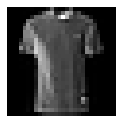

In [24]:
# Use plot_image function to display a sample that is correctly predicted
corr_ind = np.random.choice(corr_index).astype(int) 
correct_img = x_test[corr_ind] 
plt.figure(figsize=(2,2))
plot_image(correct_img, 'correctly_predicted_image', label=None)

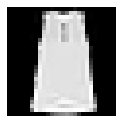

In [25]:
# Use plot_image function to display a sample that is miss-predicted
conf_ind = np.random.choice(conf_index).astype(int) # index of correctly predicted image
conf_img = x_test[conf_ind] # confusion (miss-predicted image)
plt.figure(figsize=(2,2))
plot_image(conf_img, 'miss_predicted_image', label=None)

# Effect Of Learning Rate

In [26]:
# Plot test loss as a function of epochs
num_epochs = 20
res1 = train(batchsize=50 , eta = 5e-1, num_epochs=20, h = 256, init='default')
res2 = train(batchsize=50 , eta = 1e-1, num_epochs=20, h = 256, init='default')
res3 = train(batchsize=50 , eta = 1e-2, num_epochs=20, h = 256, init='default')
res4 = train(batchsize=50 , eta = 1e-3, num_epochs=20, h = 256, init='default')

The shape of x & y train data: (3000, 785)
The shape of x_train: (3000, 784)
The shape of y_train: (3000, 1)
The shape of x & y test data: (1000, 785)
The shape of x_test: (1000, 784)
The shape of y_test: (1000, 1)




100%|██████████| 3000/3000 [00:04<00:00, 649.63it/s]


epochs: 0, Train Accuracy: 51.76666666666667%
epochs: 1, Test Accuracy: 66.10000000000001%


100%|██████████| 3000/3000 [00:04<00:00, 677.16it/s]


epochs: 1, Train Accuracy: 68.06666666666666%
epochs: 2, Test Accuracy: 69.89999999999999%


100%|██████████| 3000/3000 [00:06<00:00, 451.98it/s]


epochs: 2, Train Accuracy: 72.23333333333333%
epochs: 3, Test Accuracy: 69.6%


100%|██████████| 3000/3000 [00:04<00:00, 665.49it/s]


epochs: 3, Train Accuracy: 75.23333333333333%
epochs: 4, Test Accuracy: 67.2%


100%|██████████| 3000/3000 [00:04<00:00, 610.61it/s]


epochs: 4, Train Accuracy: 76.03333333333333%
epochs: 5, Test Accuracy: 70.8%


100%|██████████| 3000/3000 [00:04<00:00, 630.01it/s]


epochs: 5, Train Accuracy: 78.73333333333333%
epochs: 6, Test Accuracy: 70.89999999999999%


100%|██████████| 3000/3000 [00:04<00:00, 641.10it/s]


epochs: 6, Train Accuracy: 80.76666666666667%
epochs: 7, Test Accuracy: 73.3%


100%|██████████| 3000/3000 [00:04<00:00, 674.62it/s]


epochs: 7, Train Accuracy: 82.8%
epochs: 8, Test Accuracy: 75.0%


100%|██████████| 3000/3000 [00:04<00:00, 688.98it/s]


epochs: 8, Train Accuracy: 83.2%
epochs: 9, Test Accuracy: 76.5%


100%|██████████| 3000/3000 [00:04<00:00, 612.61it/s]


epochs: 9, Train Accuracy: 84.8%
epochs: 10, Test Accuracy: 77.10000000000001%


100%|██████████| 3000/3000 [00:09<00:00, 310.09it/s]


epochs: 10, Train Accuracy: 86.5%
epochs: 11, Test Accuracy: 76.5%


100%|██████████| 3000/3000 [00:07<00:00, 427.99it/s]


epochs: 11, Train Accuracy: 87.73333333333333%
epochs: 12, Test Accuracy: 77.3%


100%|██████████| 3000/3000 [00:06<00:00, 494.83it/s]


epochs: 12, Train Accuracy: 88.56666666666668%
epochs: 13, Test Accuracy: 77.8%


100%|██████████| 3000/3000 [00:04<00:00, 678.23it/s]


epochs: 13, Train Accuracy: 89.66666666666666%
epochs: 14, Test Accuracy: 78.2%


100%|██████████| 3000/3000 [00:04<00:00, 603.96it/s]


epochs: 14, Train Accuracy: 90.23333333333333%
epochs: 15, Test Accuracy: 78.0%


100%|██████████| 3000/3000 [00:04<00:00, 626.18it/s]


epochs: 15, Train Accuracy: 90.73333333333333%
epochs: 16, Test Accuracy: 78.9%


100%|██████████| 3000/3000 [00:04<00:00, 611.66it/s]


epochs: 16, Train Accuracy: 90.86666666666666%
epochs: 17, Test Accuracy: 79.10000000000001%


100%|██████████| 3000/3000 [00:04<00:00, 625.82it/s]


epochs: 17, Train Accuracy: 91.26666666666667%
epochs: 18, Test Accuracy: 78.7%


100%|██████████| 3000/3000 [00:04<00:00, 709.11it/s]


epochs: 18, Train Accuracy: 91.73333333333333%
epochs: 19, Test Accuracy: 79.0%


100%|██████████| 3000/3000 [00:04<00:00, 680.40it/s]


epochs: 19, Train Accuracy: 92.53333333333333%
epochs: 20, Test Accuracy: 78.4%
The shape of x & y train data: (3000, 785)
The shape of x_train: (3000, 784)
The shape of y_train: (3000, 1)
The shape of x & y test data: (1000, 785)
The shape of x_test: (1000, 784)
The shape of y_test: (1000, 1)




100%|██████████| 3000/3000 [00:04<00:00, 607.88it/s]


epochs: 0, Train Accuracy: 35.266666666666666%
epochs: 1, Test Accuracy: 53.1%


100%|██████████| 3000/3000 [00:05<00:00, 581.55it/s]


epochs: 1, Train Accuracy: 57.266666666666666%
epochs: 2, Test Accuracy: 60.3%


100%|██████████| 3000/3000 [00:07<00:00, 418.45it/s]


epochs: 2, Train Accuracy: 64.1%
epochs: 3, Test Accuracy: 63.800000000000004%


100%|██████████| 3000/3000 [00:05<00:00, 588.58it/s]


epochs: 3, Train Accuracy: 67.56666666666666%
epochs: 4, Test Accuracy: 65.60000000000001%


100%|██████████| 3000/3000 [00:05<00:00, 582.39it/s]


epochs: 4, Train Accuracy: 70.03333333333333%
epochs: 5, Test Accuracy: 67.30000000000001%


100%|██████████| 3000/3000 [00:05<00:00, 567.16it/s]


epochs: 5, Train Accuracy: 71.93333333333334%
epochs: 6, Test Accuracy: 68.0%


100%|██████████| 3000/3000 [00:05<00:00, 572.98it/s]


epochs: 6, Train Accuracy: 73.36666666666667%
epochs: 7, Test Accuracy: 69.3%


100%|██████████| 3000/3000 [00:05<00:00, 592.12it/s]


epochs: 7, Train Accuracy: 74.73333333333333%
epochs: 8, Test Accuracy: 69.5%


100%|██████████| 3000/3000 [00:05<00:00, 585.39it/s]


epochs: 8, Train Accuracy: 76.0%
epochs: 9, Test Accuracy: 70.0%


100%|██████████| 3000/3000 [00:05<00:00, 555.51it/s]


epochs: 9, Train Accuracy: 77.16666666666666%
epochs: 10, Test Accuracy: 70.39999999999999%


100%|██████████| 3000/3000 [00:04<00:00, 600.34it/s]


epochs: 10, Train Accuracy: 78.26666666666667%
epochs: 11, Test Accuracy: 70.8%


100%|██████████| 3000/3000 [00:05<00:00, 594.82it/s]


epochs: 11, Train Accuracy: 79.03333333333333%
epochs: 12, Test Accuracy: 70.89999999999999%


100%|██████████| 3000/3000 [00:05<00:00, 549.49it/s]


epochs: 12, Train Accuracy: 79.7%
epochs: 13, Test Accuracy: 71.2%


100%|██████████| 3000/3000 [00:05<00:00, 579.77it/s]


epochs: 13, Train Accuracy: 80.43333333333334%
epochs: 14, Test Accuracy: 71.6%


100%|██████████| 3000/3000 [00:05<00:00, 581.96it/s]


epochs: 14, Train Accuracy: 81.10000000000001%
epochs: 15, Test Accuracy: 72.0%


100%|██████████| 3000/3000 [00:05<00:00, 563.89it/s]


epochs: 15, Train Accuracy: 81.63333333333334%
epochs: 16, Test Accuracy: 72.0%


100%|██████████| 3000/3000 [00:05<00:00, 578.11it/s]


epochs: 16, Train Accuracy: 82.33333333333334%
epochs: 17, Test Accuracy: 72.39999999999999%


100%|██████████| 3000/3000 [00:05<00:00, 576.44it/s]


epochs: 17, Train Accuracy: 82.96666666666667%
epochs: 18, Test Accuracy: 72.8%


100%|██████████| 3000/3000 [00:05<00:00, 596.41it/s]


epochs: 18, Train Accuracy: 83.6%
epochs: 19, Test Accuracy: 72.8%


100%|██████████| 3000/3000 [00:05<00:00, 566.60it/s]


epochs: 19, Train Accuracy: 84.2%
epochs: 20, Test Accuracy: 73.1%
The shape of x & y train data: (3000, 785)
The shape of x_train: (3000, 784)
The shape of y_train: (3000, 1)
The shape of x & y test data: (1000, 785)
The shape of x_test: (1000, 784)
The shape of y_test: (1000, 1)




100%|██████████| 3000/3000 [00:05<00:00, 591.40it/s]


epochs: 0, Train Accuracy: 13.266666666666666%
epochs: 1, Test Accuracy: 15.299999999999999%


100%|██████████| 3000/3000 [00:04<00:00, 600.98it/s]


epochs: 1, Train Accuracy: 18.76666666666667%
epochs: 2, Test Accuracy: 22.5%


100%|██████████| 3000/3000 [00:07<00:00, 395.18it/s]


epochs: 2, Train Accuracy: 27.0%
epochs: 3, Test Accuracy: 30.5%


100%|██████████| 3000/3000 [00:05<00:00, 569.00it/s]


epochs: 3, Train Accuracy: 33.300000000000004%
epochs: 4, Test Accuracy: 37.2%


100%|██████████| 3000/3000 [00:05<00:00, 580.16it/s]


epochs: 4, Train Accuracy: 39.13333333333333%
epochs: 5, Test Accuracy: 40.9%


100%|██████████| 3000/3000 [00:05<00:00, 577.81it/s]


epochs: 5, Train Accuracy: 42.699999999999996%
epochs: 6, Test Accuracy: 44.0%


100%|██████████| 3000/3000 [00:05<00:00, 579.27it/s]


epochs: 6, Train Accuracy: 45.9%
epochs: 7, Test Accuracy: 47.099999999999994%


100%|██████████| 3000/3000 [00:05<00:00, 592.03it/s]


epochs: 7, Train Accuracy: 48.53333333333333%
epochs: 8, Test Accuracy: 49.6%


100%|██████████| 3000/3000 [00:05<00:00, 575.34it/s]


epochs: 8, Train Accuracy: 50.9%
epochs: 9, Test Accuracy: 50.9%


100%|██████████| 3000/3000 [00:05<00:00, 592.35it/s]


epochs: 9, Train Accuracy: 52.83333333333333%
epochs: 10, Test Accuracy: 52.0%


100%|██████████| 3000/3000 [00:05<00:00, 547.04it/s]


epochs: 10, Train Accuracy: 54.46666666666666%
epochs: 11, Test Accuracy: 53.300000000000004%


100%|██████████| 3000/3000 [00:05<00:00, 567.82it/s]


epochs: 11, Train Accuracy: 55.800000000000004%
epochs: 12, Test Accuracy: 54.0%


100%|██████████| 3000/3000 [00:05<00:00, 581.11it/s]


epochs: 12, Train Accuracy: 56.599999999999994%
epochs: 13, Test Accuracy: 54.6%


100%|██████████| 3000/3000 [00:05<00:00, 595.46it/s]


epochs: 13, Train Accuracy: 57.599999999999994%
epochs: 14, Test Accuracy: 55.400000000000006%


100%|██████████| 3000/3000 [00:05<00:00, 575.84it/s]


epochs: 14, Train Accuracy: 58.56666666666667%
epochs: 15, Test Accuracy: 56.39999999999999%


100%|██████████| 3000/3000 [00:04<00:00, 615.80it/s]


epochs: 15, Train Accuracy: 59.3%
epochs: 16, Test Accuracy: 57.199999999999996%


100%|██████████| 3000/3000 [00:04<00:00, 603.17it/s]


epochs: 16, Train Accuracy: 60.4%
epochs: 17, Test Accuracy: 57.9%


100%|██████████| 3000/3000 [00:05<00:00, 598.00it/s]


epochs: 17, Train Accuracy: 61.1%
epochs: 18, Test Accuracy: 58.5%


100%|██████████| 3000/3000 [00:04<00:00, 602.28it/s]


epochs: 18, Train Accuracy: 61.66666666666667%
epochs: 19, Test Accuracy: 59.4%


100%|██████████| 3000/3000 [00:04<00:00, 611.61it/s]


epochs: 19, Train Accuracy: 62.2%
epochs: 20, Test Accuracy: 59.599999999999994%
The shape of x & y train data: (3000, 785)
The shape of x_train: (3000, 784)
The shape of y_train: (3000, 1)
The shape of x & y test data: (1000, 785)
The shape of x_test: (1000, 784)
The shape of y_test: (1000, 1)




100%|██████████| 3000/3000 [00:05<00:00, 575.58it/s]


epochs: 0, Train Accuracy: 9.733333333333333%
epochs: 1, Test Accuracy: 10.299999999999999%


100%|██████████| 3000/3000 [00:04<00:00, 606.50it/s]


epochs: 1, Train Accuracy: 11.066666666666666%
epochs: 2, Test Accuracy: 11.200000000000001%


100%|██████████| 3000/3000 [00:04<00:00, 644.62it/s]


epochs: 2, Train Accuracy: 11.766666666666667%
epochs: 3, Test Accuracy: 11.899999999999999%


100%|██████████| 3000/3000 [00:06<00:00, 490.24it/s]


epochs: 3, Train Accuracy: 12.266666666666666%
epochs: 4, Test Accuracy: 13.0%


100%|██████████| 3000/3000 [00:04<00:00, 665.45it/s]


epochs: 4, Train Accuracy: 12.766666666666667%
epochs: 5, Test Accuracy: 12.8%


100%|██████████| 3000/3000 [00:04<00:00, 613.85it/s]


epochs: 5, Train Accuracy: 13.3%
epochs: 6, Test Accuracy: 13.4%


100%|██████████| 3000/3000 [00:04<00:00, 619.68it/s]


epochs: 6, Train Accuracy: 13.900000000000002%
epochs: 7, Test Accuracy: 13.600000000000001%


100%|██████████| 3000/3000 [00:06<00:00, 496.13it/s]


epochs: 7, Train Accuracy: 14.333333333333334%
epochs: 8, Test Accuracy: 14.000000000000002%


100%|██████████| 3000/3000 [00:04<00:00, 652.61it/s]


epochs: 8, Train Accuracy: 14.899999999999999%
epochs: 9, Test Accuracy: 14.499999999999998%


100%|██████████| 3000/3000 [00:04<00:00, 648.00it/s]


epochs: 9, Train Accuracy: 15.433333333333332%
epochs: 10, Test Accuracy: 15.2%


100%|██████████| 3000/3000 [00:04<00:00, 684.82it/s]


epochs: 10, Train Accuracy: 15.933333333333334%
epochs: 11, Test Accuracy: 16.1%


100%|██████████| 3000/3000 [00:04<00:00, 609.40it/s]


epochs: 11, Train Accuracy: 16.400000000000002%
epochs: 12, Test Accuracy: 17.0%


100%|██████████| 3000/3000 [00:04<00:00, 631.61it/s]


epochs: 12, Train Accuracy: 16.900000000000002%
epochs: 13, Test Accuracy: 17.599999999999998%


100%|██████████| 3000/3000 [00:05<00:00, 593.12it/s]


epochs: 13, Train Accuracy: 17.633333333333333%
epochs: 14, Test Accuracy: 17.7%


100%|██████████| 3000/3000 [00:04<00:00, 651.93it/s]


epochs: 14, Train Accuracy: 18.633333333333333%
epochs: 15, Test Accuracy: 18.7%


100%|██████████| 3000/3000 [00:04<00:00, 614.61it/s]


epochs: 15, Train Accuracy: 19.366666666666667%
epochs: 16, Test Accuracy: 19.2%


100%|██████████| 3000/3000 [00:04<00:00, 638.38it/s]


epochs: 16, Train Accuracy: 20.066666666666666%
epochs: 17, Test Accuracy: 20.200000000000003%


100%|██████████| 3000/3000 [00:04<00:00, 617.58it/s]


epochs: 17, Train Accuracy: 20.633333333333333%
epochs: 18, Test Accuracy: 20.599999999999998%


100%|██████████| 3000/3000 [00:04<00:00, 626.47it/s]


epochs: 18, Train Accuracy: 21.53333333333333%
epochs: 19, Test Accuracy: 21.0%


100%|██████████| 3000/3000 [00:04<00:00, 612.06it/s]


epochs: 19, Train Accuracy: 22.566666666666666%
epochs: 20, Test Accuracy: 22.5%


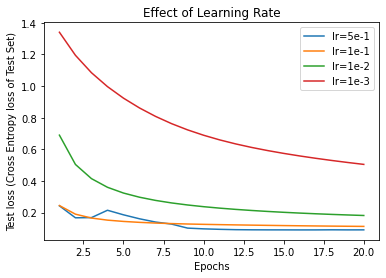

In [27]:
plt.title('Effect of Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Test loss (Cross Entropy loss of Test Set)')
plt.plot(np.linspace(1,num_epochs,num_epochs), res1[6])
plt.plot(np.linspace(1,num_epochs,num_epochs), res2[6])
plt.plot(np.linspace(1,num_epochs,num_epochs), res3[6])
plt.plot(np.linspace(1,num_epochs,num_epochs), res4[6])
plt.legend(["lr=5e-1", "lr=1e-1", "lr=1e-2", "lr=1e-3"])
plt.show()

# Effect of Initialization

In [32]:
# Plot test loss as a function of epochs
num_epochs = 20
res5 = train(batchsize=50 , eta = 0.01, num_epochs=20, h = 256, init='default')
res6 = train(batchsize=50 , eta = 0.01, num_epochs=20, h = 256, init='zeros')
res7 = train(batchsize=50 , eta = 0.01, num_epochs=20, h = 256, init='ones')
res8 = train(batchsize=50 , eta = 0.01, num_epochs=20, h = 256, init='random')

The shape of x & y train data: (3000, 785)
The shape of x_train: (3000, 784)
The shape of y_train: (3000, 1)
The shape of x & y test data: (1000, 785)
The shape of x_test: (1000, 784)
The shape of y_test: (1000, 1)




100%|██████████| 3000/3000 [00:06<00:00, 464.80it/s]


epochs: 0, Train Accuracy: 13.266666666666666%
epochs: 1, Test Accuracy: 15.299999999999999%


100%|██████████| 3000/3000 [00:06<00:00, 456.38it/s]


epochs: 1, Train Accuracy: 18.76666666666667%
epochs: 2, Test Accuracy: 22.5%


100%|██████████| 3000/3000 [00:06<00:00, 452.07it/s]


epochs: 2, Train Accuracy: 27.0%
epochs: 3, Test Accuracy: 30.5%


100%|██████████| 3000/3000 [00:06<00:00, 451.61it/s]


epochs: 3, Train Accuracy: 33.300000000000004%
epochs: 4, Test Accuracy: 37.2%


100%|██████████| 3000/3000 [00:08<00:00, 354.34it/s]


epochs: 4, Train Accuracy: 39.13333333333333%
epochs: 5, Test Accuracy: 40.9%


100%|██████████| 3000/3000 [00:06<00:00, 451.27it/s]


epochs: 5, Train Accuracy: 42.699999999999996%
epochs: 6, Test Accuracy: 44.0%


100%|██████████| 3000/3000 [00:06<00:00, 467.25it/s]


epochs: 6, Train Accuracy: 45.9%
epochs: 7, Test Accuracy: 47.099999999999994%


100%|██████████| 3000/3000 [00:06<00:00, 451.46it/s]


epochs: 7, Train Accuracy: 48.53333333333333%
epochs: 8, Test Accuracy: 49.6%


100%|██████████| 3000/3000 [00:08<00:00, 366.84it/s]


epochs: 8, Train Accuracy: 50.9%
epochs: 9, Test Accuracy: 50.9%


100%|██████████| 3000/3000 [00:06<00:00, 474.98it/s]


epochs: 9, Train Accuracy: 52.83333333333333%
epochs: 10, Test Accuracy: 52.0%


100%|██████████| 3000/3000 [00:06<00:00, 466.96it/s]


epochs: 10, Train Accuracy: 54.46666666666666%
epochs: 11, Test Accuracy: 53.300000000000004%


100%|██████████| 3000/3000 [00:06<00:00, 454.87it/s]


epochs: 11, Train Accuracy: 55.800000000000004%
epochs: 12, Test Accuracy: 54.0%


100%|██████████| 3000/3000 [00:06<00:00, 453.75it/s]


epochs: 12, Train Accuracy: 56.599999999999994%
epochs: 13, Test Accuracy: 54.6%


100%|██████████| 3000/3000 [00:06<00:00, 441.48it/s]


epochs: 13, Train Accuracy: 57.599999999999994%
epochs: 14, Test Accuracy: 55.400000000000006%


100%|██████████| 3000/3000 [00:07<00:00, 426.38it/s]


epochs: 14, Train Accuracy: 58.56666666666667%
epochs: 15, Test Accuracy: 56.39999999999999%


100%|██████████| 3000/3000 [00:06<00:00, 450.61it/s]


epochs: 15, Train Accuracy: 59.3%
epochs: 16, Test Accuracy: 57.199999999999996%


100%|██████████| 3000/3000 [00:06<00:00, 453.91it/s]


epochs: 16, Train Accuracy: 60.4%
epochs: 17, Test Accuracy: 57.9%


100%|██████████| 3000/3000 [00:06<00:00, 455.97it/s]


epochs: 17, Train Accuracy: 61.1%
epochs: 18, Test Accuracy: 58.5%


100%|██████████| 3000/3000 [00:06<00:00, 461.47it/s]


epochs: 18, Train Accuracy: 61.66666666666667%
epochs: 19, Test Accuracy: 59.4%


100%|██████████| 3000/3000 [00:06<00:00, 438.47it/s]


epochs: 19, Train Accuracy: 62.2%
epochs: 20, Test Accuracy: 59.599999999999994%
The shape of x & y train data: (3000, 785)
The shape of x_train: (3000, 784)
The shape of y_train: (3000, 1)
The shape of x & y test data: (1000, 785)
The shape of x_test: (1000, 784)
The shape of y_test: (1000, 1)




100%|██████████| 3000/3000 [00:08<00:00, 352.34it/s]


epochs: 0, Train Accuracy: 8.866666666666667%
epochs: 1, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 489.93it/s]


epochs: 1, Train Accuracy: 8.366666666666667%
epochs: 2, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 462.78it/s]


epochs: 2, Train Accuracy: 8.366666666666667%
epochs: 3, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 444.56it/s]


epochs: 3, Train Accuracy: 8.366666666666667%
epochs: 4, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 446.24it/s]


epochs: 4, Train Accuracy: 8.366666666666667%
epochs: 5, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 444.38it/s]


epochs: 5, Train Accuracy: 8.366666666666667%
epochs: 6, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 446.26it/s]


epochs: 6, Train Accuracy: 8.366666666666667%
epochs: 7, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 474.62it/s]


epochs: 7, Train Accuracy: 8.366666666666667%
epochs: 8, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 467.49it/s]


epochs: 8, Train Accuracy: 8.366666666666667%
epochs: 9, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 443.23it/s]


epochs: 9, Train Accuracy: 8.366666666666667%
epochs: 10, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 464.15it/s]


epochs: 10, Train Accuracy: 8.366666666666667%
epochs: 11, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 463.35it/s]


epochs: 11, Train Accuracy: 8.366666666666667%
epochs: 12, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 430.22it/s]


epochs: 12, Train Accuracy: 8.366666666666667%
epochs: 13, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 464.78it/s]


epochs: 13, Train Accuracy: 8.366666666666667%
epochs: 14, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 480.52it/s]


epochs: 14, Train Accuracy: 8.366666666666667%
epochs: 15, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 451.51it/s]


epochs: 15, Train Accuracy: 8.366666666666667%
epochs: 16, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 454.59it/s]


epochs: 16, Train Accuracy: 8.366666666666667%
epochs: 17, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:08<00:00, 340.02it/s]


epochs: 17, Train Accuracy: 8.366666666666667%
epochs: 18, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 450.87it/s]


epochs: 18, Train Accuracy: 8.366666666666667%
epochs: 19, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 442.92it/s]


epochs: 19, Train Accuracy: 8.366666666666667%
epochs: 20, Test Accuracy: 10.0%
The shape of x & y train data: (3000, 785)
The shape of x_train: (3000, 784)
The shape of y_train: (3000, 1)
The shape of x & y test data: (1000, 785)
The shape of x_test: (1000, 784)
The shape of y_test: (1000, 1)




100%|██████████| 3000/3000 [00:06<00:00, 474.27it/s]


epochs: 0, Train Accuracy: 9.766666666666666%
epochs: 1, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 471.40it/s]


epochs: 1, Train Accuracy: 9.566666666666666%
epochs: 2, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 443.70it/s]


epochs: 2, Train Accuracy: 9.566666666666666%
epochs: 3, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 458.15it/s]


epochs: 3, Train Accuracy: 9.566666666666666%
epochs: 4, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 460.61it/s]


epochs: 4, Train Accuracy: 9.566666666666666%
epochs: 5, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 437.33it/s]


epochs: 5, Train Accuracy: 9.566666666666666%
epochs: 6, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 446.43it/s]


epochs: 6, Train Accuracy: 9.566666666666666%
epochs: 7, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 437.93it/s]


epochs: 7, Train Accuracy: 9.566666666666666%
epochs: 8, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 443.64it/s]


epochs: 8, Train Accuracy: 9.566666666666666%
epochs: 9, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 445.12it/s]


epochs: 9, Train Accuracy: 9.566666666666666%
epochs: 10, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 452.67it/s]


epochs: 10, Train Accuracy: 9.566666666666666%
epochs: 11, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 431.29it/s]


epochs: 11, Train Accuracy: 9.566666666666666%
epochs: 12, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:07<00:00, 389.20it/s]


epochs: 12, Train Accuracy: 9.566666666666666%
epochs: 13, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:07<00:00, 386.61it/s]


epochs: 13, Train Accuracy: 9.566666666666666%
epochs: 14, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 450.24it/s]


epochs: 14, Train Accuracy: 9.566666666666666%
epochs: 15, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 446.68it/s]


epochs: 15, Train Accuracy: 9.566666666666666%
epochs: 16, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 442.02it/s]


epochs: 16, Train Accuracy: 9.566666666666666%
epochs: 17, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 433.72it/s]


epochs: 17, Train Accuracy: 9.566666666666666%
epochs: 18, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 445.88it/s]


epochs: 18, Train Accuracy: 9.566666666666666%
epochs: 19, Test Accuracy: 10.0%


100%|██████████| 3000/3000 [00:06<00:00, 475.84it/s]


epochs: 19, Train Accuracy: 9.566666666666666%
epochs: 20, Test Accuracy: 10.0%
The shape of x & y train data: (3000, 785)
The shape of x_train: (3000, 784)
The shape of y_train: (3000, 1)
The shape of x & y test data: (1000, 785)
The shape of x_test: (1000, 784)
The shape of y_test: (1000, 1)




100%|██████████| 3000/3000 [00:06<00:00, 452.85it/s]


epochs: 0, Train Accuracy: 12.133333333333333%
epochs: 1, Test Accuracy: 17.5%


100%|██████████| 3000/3000 [00:06<00:00, 447.42it/s]


epochs: 1, Train Accuracy: 25.133333333333336%
epochs: 2, Test Accuracy: 32.800000000000004%


100%|██████████| 3000/3000 [00:06<00:00, 433.49it/s]


epochs: 2, Train Accuracy: 37.333333333333336%
epochs: 3, Test Accuracy: 42.3%


100%|██████████| 3000/3000 [00:06<00:00, 438.21it/s]


epochs: 3, Train Accuracy: 44.36666666666667%
epochs: 4, Test Accuracy: 47.199999999999996%


100%|██████████| 3000/3000 [00:06<00:00, 440.58it/s]


epochs: 4, Train Accuracy: 49.7%
epochs: 5, Test Accuracy: 51.800000000000004%


100%|██████████| 3000/3000 [00:07<00:00, 427.89it/s]


epochs: 5, Train Accuracy: 54.0%
epochs: 6, Test Accuracy: 54.7%


100%|██████████| 3000/3000 [00:06<00:00, 446.76it/s]


epochs: 6, Train Accuracy: 57.099999999999994%
epochs: 7, Test Accuracy: 56.99999999999999%


100%|██████████| 3000/3000 [00:06<00:00, 443.73it/s]


epochs: 7, Train Accuracy: 58.733333333333334%
epochs: 8, Test Accuracy: 58.4%


100%|██████████| 3000/3000 [00:08<00:00, 349.92it/s]


epochs: 8, Train Accuracy: 60.83333333333333%
epochs: 9, Test Accuracy: 59.9%


100%|██████████| 3000/3000 [00:06<00:00, 453.78it/s]


epochs: 9, Train Accuracy: 62.66666666666667%
epochs: 10, Test Accuracy: 60.699999999999996%


100%|██████████| 3000/3000 [00:07<00:00, 425.98it/s]


epochs: 10, Train Accuracy: 63.5%
epochs: 11, Test Accuracy: 61.5%


100%|██████████| 3000/3000 [00:06<00:00, 428.84it/s]


epochs: 11, Train Accuracy: 64.2%
epochs: 12, Test Accuracy: 61.9%


100%|██████████| 3000/3000 [00:07<00:00, 428.52it/s]


epochs: 12, Train Accuracy: 65.06666666666666%
epochs: 13, Test Accuracy: 62.6%


100%|██████████| 3000/3000 [00:06<00:00, 434.28it/s]


epochs: 13, Train Accuracy: 65.63333333333333%
epochs: 14, Test Accuracy: 63.1%


100%|██████████| 3000/3000 [00:06<00:00, 453.45it/s]


epochs: 14, Train Accuracy: 66.36666666666666%
epochs: 15, Test Accuracy: 63.9%


100%|██████████| 3000/3000 [00:06<00:00, 439.19it/s]


epochs: 15, Train Accuracy: 67.43333333333334%
epochs: 16, Test Accuracy: 64.7%


100%|██████████| 3000/3000 [00:06<00:00, 438.75it/s]


epochs: 16, Train Accuracy: 68.06666666666666%
epochs: 17, Test Accuracy: 65.3%


100%|██████████| 3000/3000 [00:06<00:00, 461.39it/s]


epochs: 17, Train Accuracy: 68.56666666666666%
epochs: 18, Test Accuracy: 66.0%


100%|██████████| 3000/3000 [00:06<00:00, 452.90it/s]


epochs: 18, Train Accuracy: 69.1%
epochs: 19, Test Accuracy: 66.3%


100%|██████████| 3000/3000 [00:07<00:00, 425.83it/s]


epochs: 19, Train Accuracy: 69.69999999999999%
epochs: 20, Test Accuracy: 67.10000000000001%


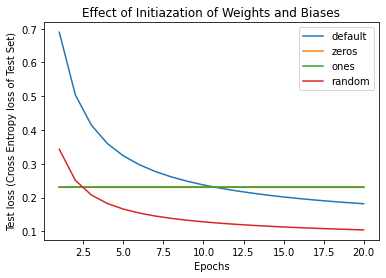

In [33]:
plt.title('Effect of Initiazation of Weights and Biases')
plt.xlabel('Epochs')
plt.ylabel('Test loss (Cross Entropy loss of Test Set)')
plt.plot(np.linspace(1,num_epochs,num_epochs), res5[6])
plt.plot(np.linspace(1,num_epochs,num_epochs), res6[6])
plt.plot(np.linspace(1,num_epochs,num_epochs), res7[6])
plt.plot(np.linspace(1,num_epochs,num_epochs), res8[6])
plt.legend(["default", "zeros", "ones", "random"])
# plt.legend(["default", "zeros", "ones"])
plt.show()